## 迁移学习
- 用人家训练好模型的权重参数当做咱们的初始化
- 一般全连接层需要自己训练，可以选择是否训练别人训练好的特征提取层

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### tensorflow.keras.applications
- 里面有很多现成训练好的模型可以直接利用

In [3]:
### 导入模型
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
pre_trained_model = ResNet101(input_shape = (75, 75, 3), # 输入大小
                                include_top = False, # 不要最后的全连接层
                                weights = 'imagenet')

171450368/171446536 [==============================] - 21s 0us/step


可以选择训练哪些层

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False

### callback的作用

- 相当于一个监视器，在训练过程中可以设置一些自定义项，比如提前停止，改变学习率等

callbacks = [

  如果连续两个epoch还没降低就停止：
  
      tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  
  可以动态改变学习率：
  
      tf.keras.callbacks.LearningRateScheduler
      
  保存模型：
  
      tf.keras.callbacks.ModelCheckpoint
      
  自定义方法：
  
      tf.keras.callbacks.Callback
]

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [7]:
from tensorflow.keras.optimizers import Adam

# 为全连接层准备
x = layers.Flatten()(pre_trained_model.output)
# 加入全连接层，这个需要重头训练的
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
# 输出层
x = layers.Dense(1, activation='sigmoid')(x)           
# 构建模型序列
model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (75, 75))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (75, 75))

Found 2001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 训练模型
- 加入Callback()模块

In [9]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
100/100 - 135s - loss: 1.2519 - acc: 0.5255 - val_loss: 0.6941 - val_acc: 0.5660
Epoch 2/100
100/100 - 145s - loss: 0.7611 - acc: 0.5230 - val_loss: 0.6714 - val_acc: 0.6060
Epoch 3/100
100/100 - 104s - loss: 0.6899 - acc: 0.5422 - val_loss: 0.6692 - val_acc: 0.6020
Epoch 4/100
100/100 - 82s - loss: 0.6927 - acc: 0.5326 - val_loss: 0.6768 - val_acc: 0.5970
Epoch 5/100
100/100 - 111s - loss: 0.6893 - acc: 0.5452 - val_loss: 0.6749 - val_acc: 0.5770
Epoch 6/100
100/100 - 88s - loss: 0.6844 - acc: 0.5447 - val_loss: 0.6724 - val_acc: 0.6160
Epoch 7/100
100/100 - 90s - loss: 0.6831 - acc: 0.5634 - val_loss: 0.6694 - val_acc: 0.6250
Epoch 8/100
100/100 - 116s - loss: 0.6841 - acc: 0.5654 - val_loss: 0.6711 - val_acc: 0.6240
Epoch 9/100
100/100 - 127s - loss: 0.6823 - acc: 0.5699 - val_loss: 0.6695 - val_acc: 0.5980
Epoch 10/100
100/100 - 145s - loss: 0.6843 - acc: 0.5472 - val_loss: 0.6661 - val_acc: 0.6060
Epoch 11/100
100/100 - 119s - loss: 0.6768 - acc: 0.5815 - val_loss: 0.6

绘图展示

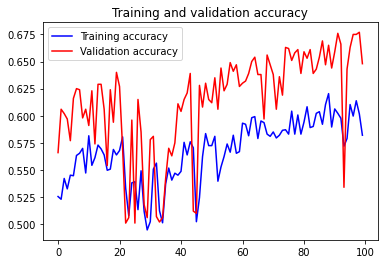

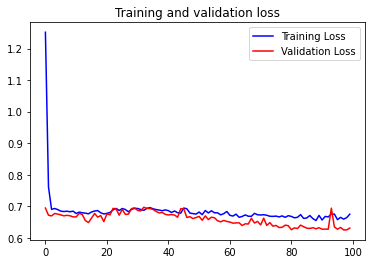

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 也可以自己选择需要的层，也就是取到哪一层

- last_layer = pre_trained_model.get_layer('层的名字') 